## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms.v2 as transforms
from torchinfo import summary
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt

from data import plot_examples, split_dataset, transform_to_tensor, transform_crop_and_resize, transform_res_net_18, transform_mnasnet_0_75, transform_3_channels, transform_to_image
from model import PneumoniaDetectionResNet18Model, PneumoniaDetectionMobileNetV3LargeModel, PneumoniaDetectionMNASNet0_75Model
from trainer import Trainer
from eval import evaluate_training, evaluate_test, plot_loss, get_wrong_classifications, get_true_classification_samples, interpret_viz
from datetime import datetime

/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global Parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

allow_restnet18_training = False
resnet18_model_path = "checkpoints/2023_12_06_PneumoniaDetectionResNet18Model.pth"

allow_mobile_v3_large_training = False
mobile_v3_large_model_path = "checkpoints/2023_12_06_PneumoniaDetectionMobileNetV3LargeModel.pth"

allow_mnasnet_0_75_training = False
mnasnet_0_75_model_path = "checkpoints/2023_12_06_PneumoniaDetectionMNASNet0_75Model.pth"

allow_testing = False
nih_test_dataset_path = "data/nih_test_dataset/"

## 2. Dataset

Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [3]:
train_set = torchvision.datasets.ImageFolder(root="data/train", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
validation_set = torchvision.datasets.ImageFolder(root="data/val", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
merged_dataset = ConcatDataset([train_set, validation_set])
train_set, validation_set = split_dataset(merged_dataset, 0.7)

classes = merged_dataset.datasets[0].classes
print(f"Classes: {classes}")

Classes: ['NORMAL', 'PNEUMONIA']


In [4]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))

<Figure size 1200x700 with 0 Axes>

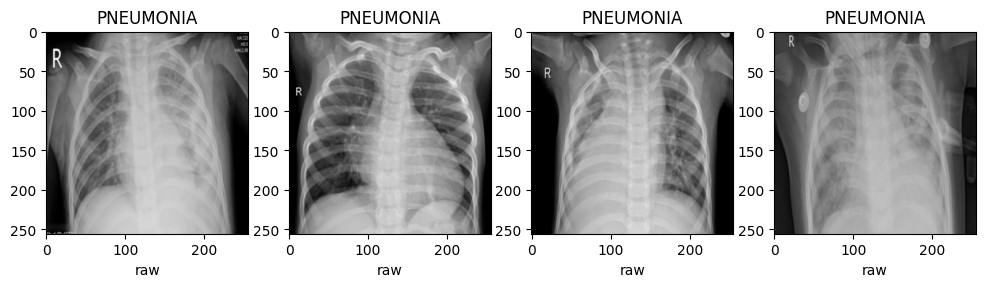

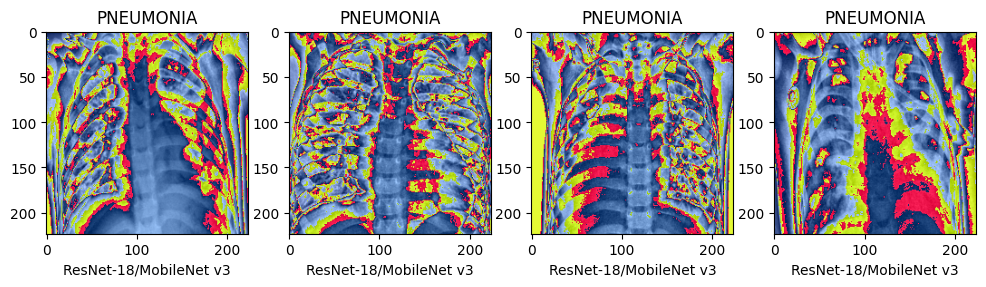

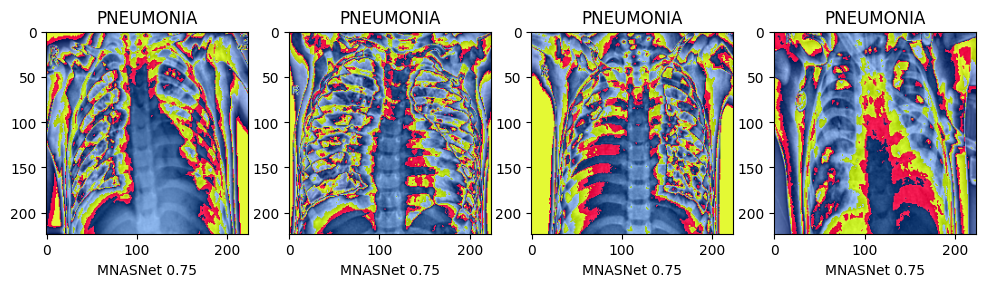

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

figure = plt.figure(figsize=(12, 7))
plot_examples("raw", images, labels, classes, transform_crop_and_resize)
plot_examples("ResNet-18/MobileNet v3", images, labels, classes, transform_res_net_18)
plot_examples("MNASNet 0.75", images, labels, classes, transform_mnasnet_0_75)
plt.show()

## 3. Model

### 3.1 ResNet-18

In [6]:
resnet18_model = PneumoniaDetectionResNet18Model()
summary(resnet18_model, input_size=(batch_size, 3, 224, 224), device=device, dtypes=[torch.float32])

/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/torch/nn/functional.py:4010: UserWarning: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn._upsample_bilinear2d_aa(input, output_size, align_corners, scale_factors)


Layer (type:depth-idx)                        Output Shape              Param #
├─ImageClassification: 1-1                    [32, 3, 224, 224]         --
├─ResNet: 1-2                                 [32, 2]                   --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [32, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]         295,42

### 3.2 MobileNet v3

In [7]:
mobile_v3_large_model = PneumoniaDetectionMobileNetV3LargeModel()
summary(mobile_v3_large_model, input_size=(batch_size, 3, 224, 224), device=device, dtypes=[torch.float32])

Layer (type:depth-idx)                                  Output Shape              Param #
├─ImageClassification: 1-1                              [32, 3, 224, 224]         --
├─MobileNetV3: 1-2                                      [32, 2]                   --
│    └─Sequential: 2-1                                  [32, 960, 7, 7]           --
│    │    └─Conv2dNormActivation: 3-1                   [32, 16, 112, 112]        464
│    │    └─InvertedResidual: 3-2                       [32, 16, 112, 112]        464
│    │    └─InvertedResidual: 3-3                       [32, 24, 56, 56]          3,440
│    │    └─InvertedResidual: 3-4                       [32, 24, 56, 56]          4,440
│    │    └─InvertedResidual: 3-5                       [32, 40, 28, 28]          10,328
│    │    └─InvertedResidual: 3-6                       [32, 40, 28, 28]          20,992
│    │    └─InvertedResidual: 3-7                       [32, 40, 28, 28]          20,992
│    │    └─InvertedResidual: 3-8       

### 3.3 MNASNet 0.75

In [8]:
mnasnet_0_75_model = PneumoniaDetectionMNASNet0_75Model()
summary(mnasnet_0_75_model, input_size=(batch_size, 3, 224, 224), device=device, dtypes=[torch.float32])

Layer (type:depth-idx)                             Output Shape              Param #
├─ImageClassification: 1-1                         [32, 3, 224, 224]         --
├─MNASNet: 1-2                                     [32, 2]                   --
│    └─Sequential: 2-1                             [32, 1280, 7, 7]          --
│    │    └─Conv2d: 3-1                            [32, 24, 112, 112]        (648)
│    │    └─BatchNorm2d: 3-2                       [32, 24, 112, 112]        (48)
│    │    └─ReLU: 3-3                              [32, 24, 112, 112]        --
│    │    └─Conv2d: 3-4                            [32, 24, 112, 112]        (216)
│    │    └─BatchNorm2d: 3-5                       [32, 24, 112, 112]        (48)
│    │    └─ReLU: 3-6                              [32, 24, 112, 112]        --
│    │    └─Conv2d: 3-7                            [32, 16, 112, 112]        (384)
│    │    └─BatchNorm2d: 3-8                       [32, 16, 112, 112]        (32)
│    │    └─Sequenti

## 4. Train

In [9]:
loss_fn = nn.CrossEntropyLoss()

### 4.1 ResNet-18

In [10]:
adam_optimizer = optim.Adam(resnet18_model.parameters(), lr=0.00001)
resnet18_trainer = Trainer(resnet18_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=3)

In [11]:
if allow_restnet18_training:
    resnet18_trainer.fit()

    # save model and training history
    resnet18_model.set_history(resnet18_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({ 
        "state_dict": resnet18_model.state_dict(),
        "history": resnet18_model.history
    }, 
    f"checkpoints/{today}_{resnet18_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(resnet18_model_path)
    resnet18_model.load_state_dict(checkpoint['state_dict'])
    resnet18_model.set_history(checkpoint['history'])

### 4.2 MobileNet v3

In [12]:
adam_optimizer = optim.Adam(mobile_v3_large_model.parameters(), lr=0.00001)
mobile_v3_large_trainer = Trainer(mobile_v3_large_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=8)

In [13]:
if allow_mobile_v3_large_training:
    mobile_v3_large_trainer.fit()

    # save model and training history
    mobile_v3_large_model.set_history(mobile_v3_large_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({
        "state_dict": mobile_v3_large_model.state_dict(),
        "history": mobile_v3_large_model.history
    }, f"checkpoints/{today}_{mobile_v3_large_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(mobile_v3_large_model_path)
    mobile_v3_large_model.load_state_dict(checkpoint["state_dict"])
    mobile_v3_large_model.set_history(checkpoint["history"])

### 4.3 MNASNet 0.75

In [14]:
adam_optimizer = optim.Adam(mnasnet_0_75_model.parameters())
mnasnet_0_75_trainer = Trainer(mnasnet_0_75_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=20)

In [15]:
if allow_mnasnet_0_75_training:
    mnasnet_0_75_trainer.fit()

    # save model and training history
    mnasnet_0_75_model.set_history(mnasnet_0_75_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({
        "state_dict": mnasnet_0_75_model.state_dict(),
        "history": mnasnet_0_75_model.history
    }, f"checkpoints/{today}_{mnasnet_0_75_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(mnasnet_0_75_model_path)
    mnasnet_0_75_model.load_state_dict(checkpoint["state_dict"])
    mnasnet_0_75_model.set_history(checkpoint["history"])

## 5. Evaluation

### 5.1 ResNet-18

[PneumoniaDetectionResNet18Model] Train f1 score: 0.9893500804901123
[PneumoniaDetectionResNet18Model] Validation f1 score: 0.993630588054657


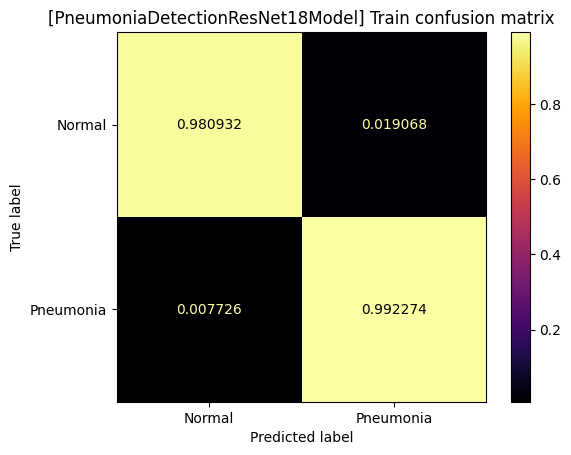

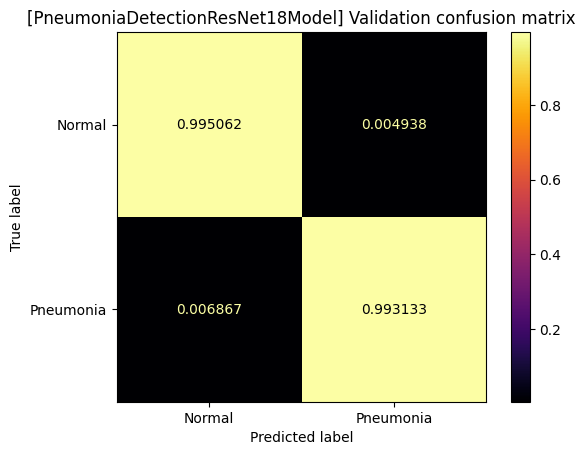

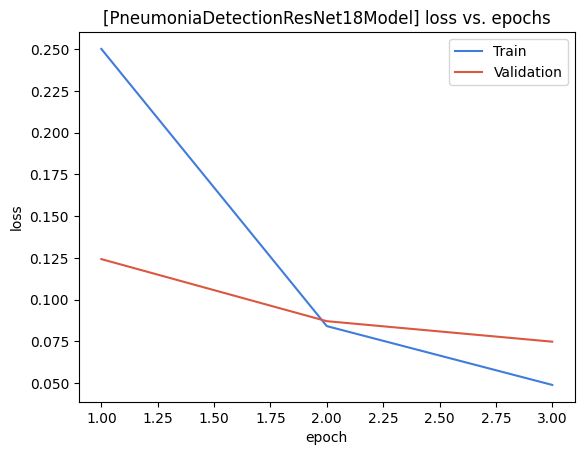

In [16]:
evaluate_training(resnet18_model, train_loader, validation_loader, device=device)
plot_loss(resnet18_model)

### 5.2 MobileNet v3

[PneumoniaDetectionMobileNetV3LargeModel] Train f1 score: 0.9852539300918579
[PneumoniaDetectionMobileNetV3LargeModel] Validation f1 score: 0.9885350465774536


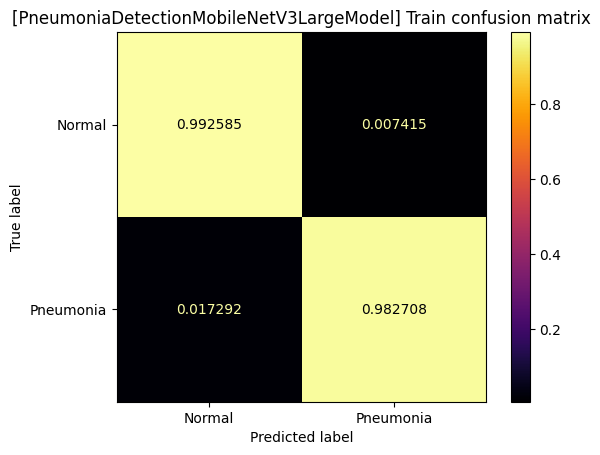

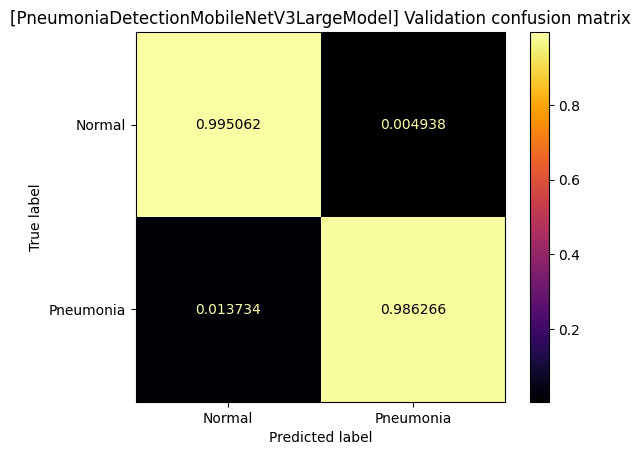

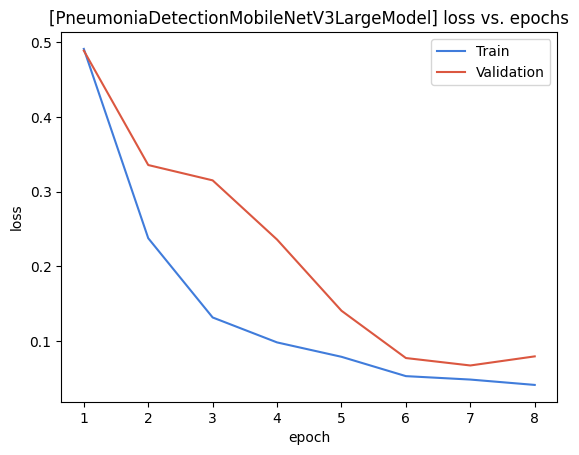

In [17]:
evaluate_training(mobile_v3_large_model, train_loader, validation_loader, device=device)
plot_loss(mobile_v3_large_model)

### 5.3 MNASNet 0.75

[PneumoniaDetectionMNASNet0_75Model] Train f1 score: 0.8096668720245361
[PneumoniaDetectionMNASNet0_75Model] Validation f1 score: 0.8267515897750854


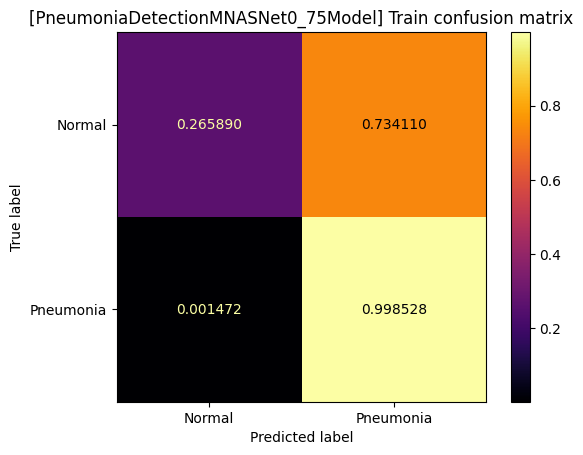

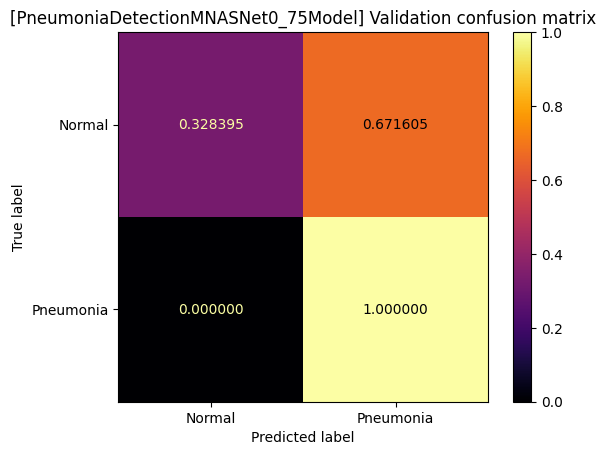

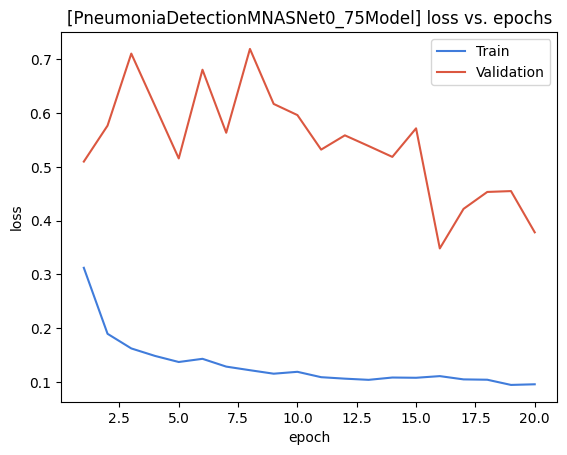

In [18]:
evaluate_training(mnasnet_0_75_model, train_loader, validation_loader, device=device)
plot_loss(mnasnet_0_75_model)

## 6. Test

### 6.1 Guangzhou Women and Children’s Medical Center

In [19]:
if allow_testing:
    test_set = torchvision.datasets.ImageFolder(root="data/test", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
    test_loader = DataLoader(test_set, batch_size=batch_size)

    evaluate_test(resnet18_model, test_loader, device=device)
    evaluate_test(mobile_v3_large_model, test_loader, device=device)
    evaluate_test(mnasnet_0_75_model, test_loader, device=device)

### 6.2 NIH Dataset

In [20]:
# unbalanced data might be the issue
# analyse images that were wrongly classified to check waht is wrong ("the 1%") 

if allow_testing:
    nih_test_dataset = load_from_disk(nih_test_dataset_path).with_format("torch")
    nih_test_dataset.set_transform(transforms.Compose([transform_3_channels, transform_to_tensor, transform_crop_and_resize]))
    nih_test_dataset_dataloader = DataLoader(nih_test_dataset, batch_size=32, num_workers=4)

    evaluate_test(resnet18_model, nih_test_dataset_dataloader, device=device)
    evaluate_test(mobile_v3_large_model, nih_test_dataset_dataloader, device=device)
    evaluate_test(mnasnet_0_75_model, nih_test_dataset_dataloader, device=device)

## 7. Interpretability

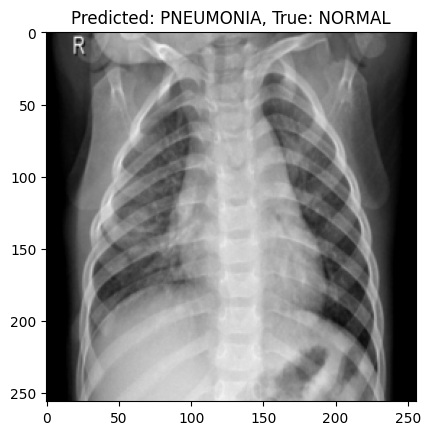

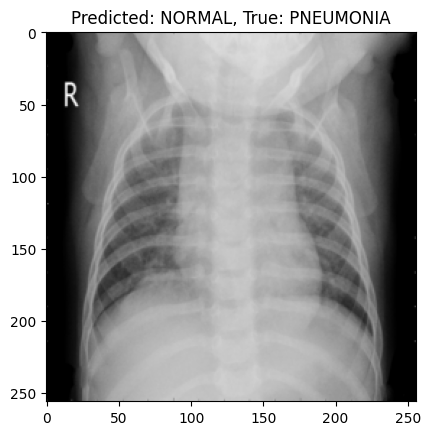

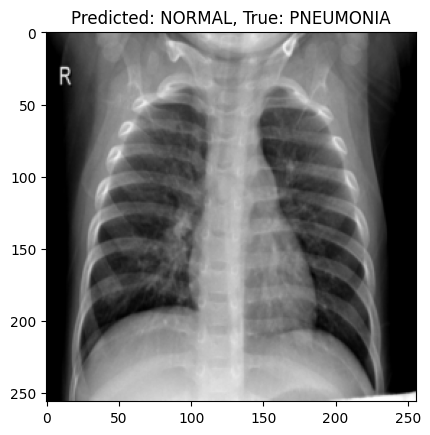

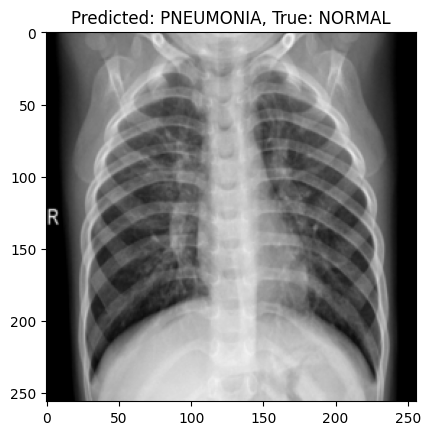

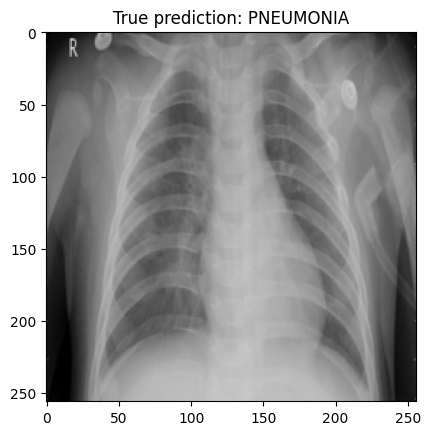

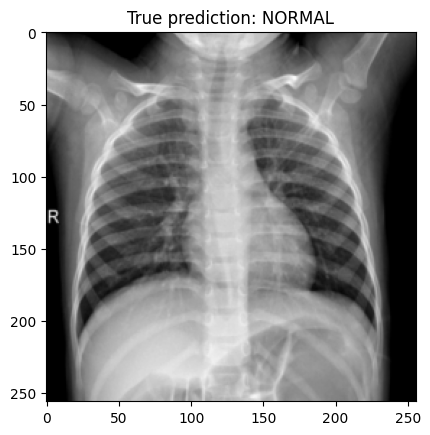

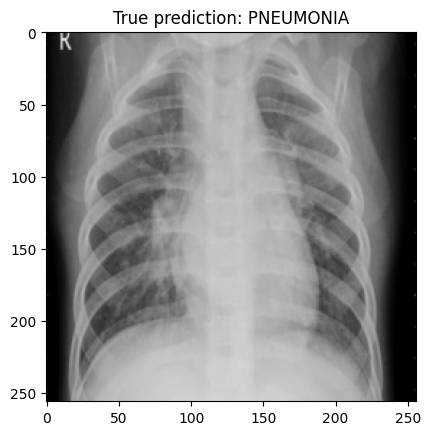

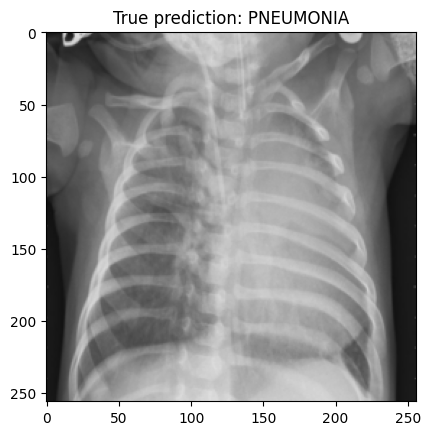

In [21]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(123123))
wrong_classifications = get_wrong_classifications(resnet18_model, train_loader, device=device)
true_classifications = get_true_classification_samples(resnet18_model, train_loader, samples=4, device=device)
for img, predicted_label,true_label in wrong_classifications[:4]:
    plt.title(f"Predicted: {classes[predicted_label]}, True: {classes[true_label]}")
    plt.imshow(transform_to_image(img))
    plt.show()

for img, predicted_label,true_label in true_classifications[:4]:
    plt.title(f"True prediction: {classes[true_label]}")
    plt.imshow(transform_to_image(img))
    plt.show()

In [22]:
images, labels = next(iter(validation_loader))
image, label = images[0].to("cpu").unsqueeze(0), labels[0].to("cpu").item()

### 7.1 ResNet-18

Label: PNEUMONIA
Prediction: 0.9933777451515198
Predicted: PNEUMONIA


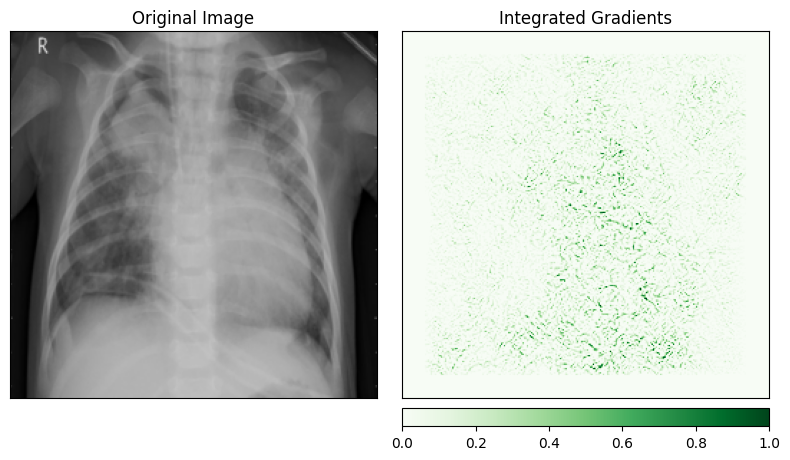

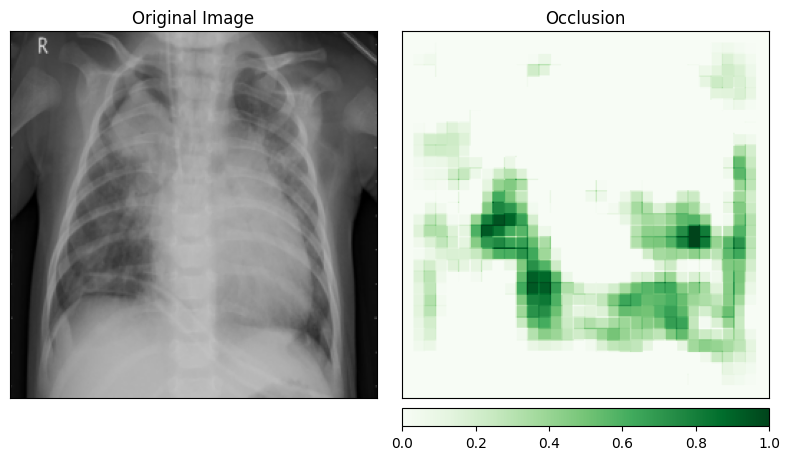

In [23]:
interpret_viz(resnet18_model, image, label, classes)

### 7.2 MobileNet v3

Label: PNEUMONIA
Prediction: 0.9998444318771362
Predicted: PNEUMONIA


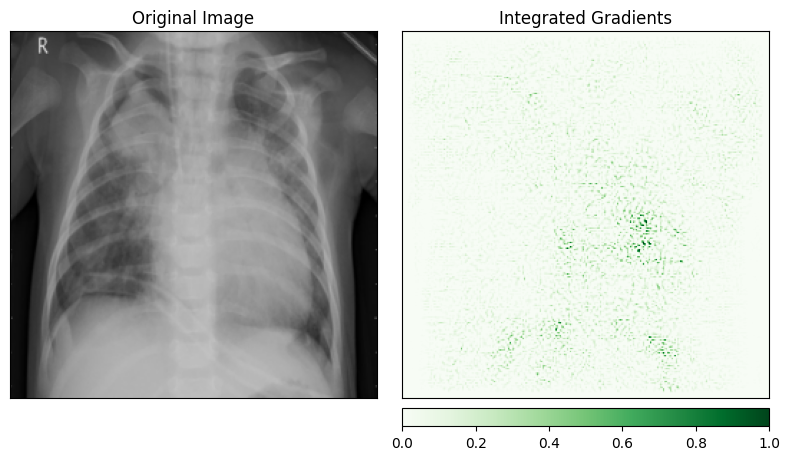

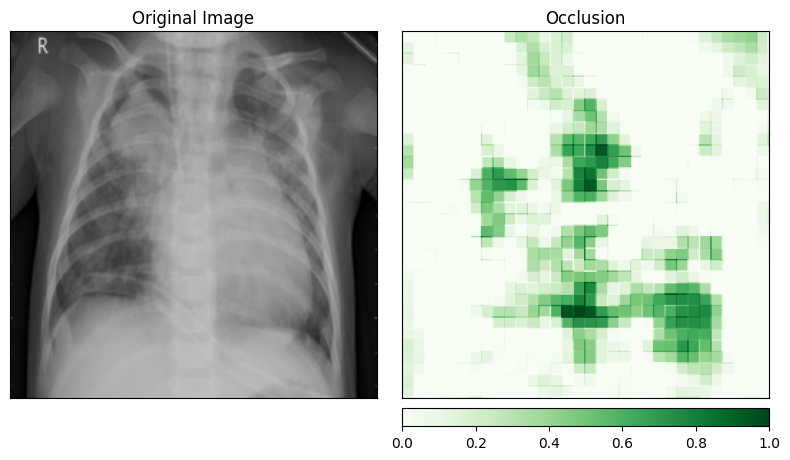

In [24]:
interpret_viz(mobile_v3_large_model, image, label, classes)

### 7.3 MNASNet 0.75

Label: PNEUMONIA
Prediction: 0.9719203114509583
Predicted: PNEUMONIA


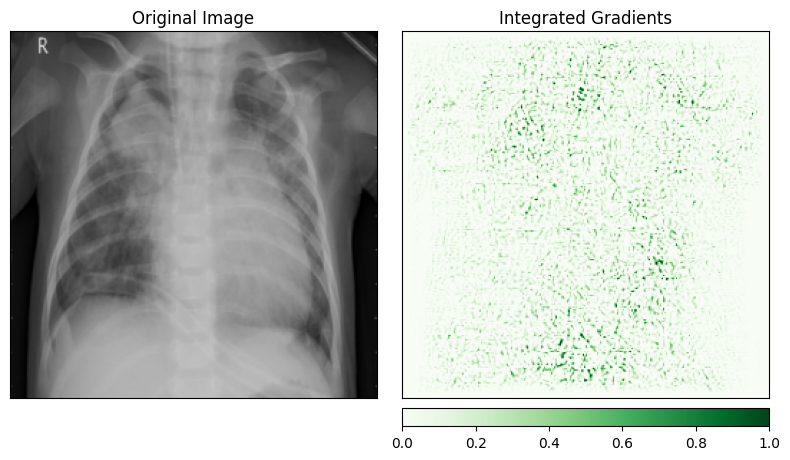

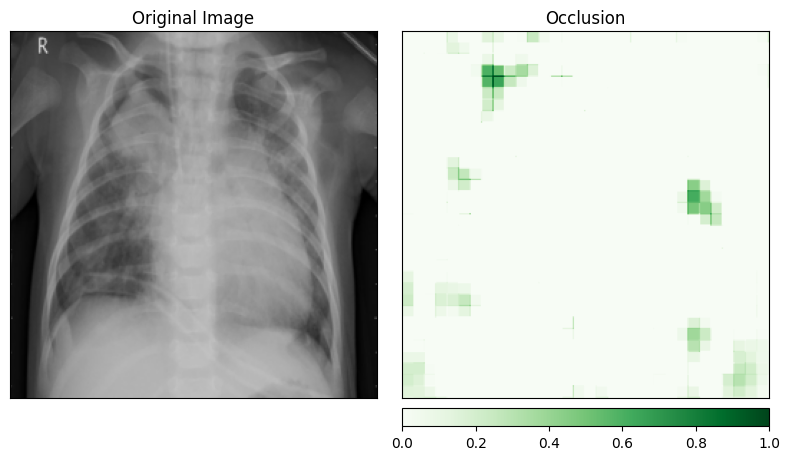

In [25]:
interpret_viz(mnasnet_0_75_model, image, label, classes)